# Synthetic data validation
This notebook explores how human-like is the generated synthetic data via different evaluation metrics explained below.

In [1]:
import pandas as pd
df = pd.read_csv("cleaned_synthetic_data.csv")

## Perplexity
In simple terms, it tells you how “surprised” the model is by the actual text:

Lower perplexity means the model predicts the text well (less surprise).

Higher perplexity means the model struggles to predict the text (more surprise).

In [2]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()

def compute_perplexity(text):
    encodings = tokenizer(text, return_tensors='pt')
    input_ids = encodings.input_ids
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

df['perplexity'] = df['synthetic_text'].apply(compute_perplexity)
print(df[['synthetic_text','perplexity']].head())

avg_perplexity = df['perplexity'].mean()
print("Average Perplexity:", avg_perplexity)


c:\Users\Lenovo X1 Carbon\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


                                      synthetic_text  perplexity
0  I spent the morning organizing my planner. I a...   80.624069
1  I joined a new study group today. Everyone was...   47.668018
2  I reorganized my bookshelf by topic and author...   39.959263
3  I spent two hours debugging my code. I finally...   27.968117
4  I forgot my umbrella and got soaked. Then I mi...   68.441299
Average Perplexity: 53.20845436249803


An average perplexity of 53 is quite good for short synthetic journal entries. It’s low enough to indicate that the text is fluent and grammatical, but the high variance is not surprising - short texts are more sensitive and a single unusual sentence can spike perplexity. For this dataset, this value suggests the generator is doing a reasonable job.
## Readability
Sentence length and word complexity

Flesch Reading Ease gives a score from 0 to 100, where higher means easier to read. For example, simple children’s books might score around 90, while dense academic writing might score below 30.

Flesch–Kincaid Grade Level converts that same information into a U.S. school grade level. For instance, a score of 8.0 means an eighth grader should be able to understand the text.


In [3]:
import textstat

df['flesch_reading_ease'] = df['synthetic_text'].apply(textstat.flesch_reading_ease)
df['flesch_kincaid_grade'] = df['synthetic_text'].apply(textstat.flesch_kincaid_grade)

print("Average Flesch Reading Ease:", df['flesch_reading_ease'].mean())
print("Average Flesch-Kincaid Grade Level:", df['flesch_kincaid_grade'].mean())


Average Flesch Reading Ease: 65.14514050009753
Average Flesch-Kincaid Grade Level: 8.4664391865969


Flesch Reading Ease (0–100):
Average 65 - standard, conversational English. This is very natural for short journal-style writing.

Flesch-Kincaid Grade Level:
Average 8.5 - roughly 8th–9th grade reading level, which is appropriate for general adult writing.

Takeaway:
The synthetic entries are readable, mostly clear, and not overly complex.
Some variation exists, but that’s actually realistic—journals often mix simple and slightly longer sentences.
## Sentence Length Distribution

Average sentence length: 9.811419984973703
Median sentence length: 6.0
Min sentence length: 1
Max sentence length: 46


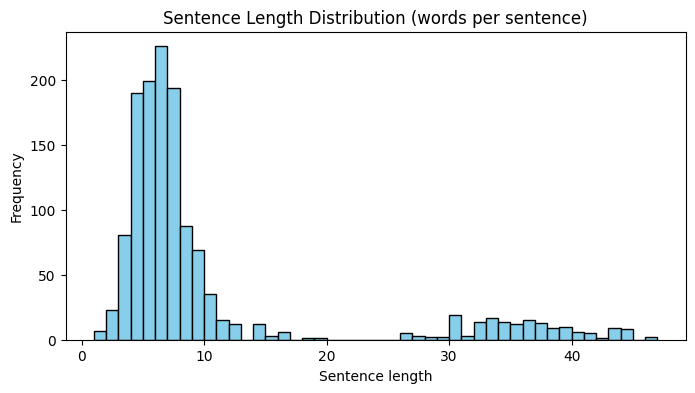

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def sentence_lengths(text):
    sentences = text.split('.') 
    sentences = [s.strip() for s in sentences if len(s.strip()) > 0]
    return [len(s.split()) for s in sentences]

df['sentence_lengths'] = df['synthetic_text'].apply(sentence_lengths)

all_lengths = [length for sublist in df['sentence_lengths'] for length in sublist]

print("Average sentence length:", np.mean(all_lengths))
print("Median sentence length:", np.median(all_lengths))
print("Min sentence length:", np.min(all_lengths))
print("Max sentence length:", np.max(all_lengths))

plt.figure(figsize=(8,4))
plt.hist(all_lengths, bins=range(1, max(all_lengths)+2), color='skyblue', edgecolor='black')
plt.title("Sentence Length Distribution (words per sentence)")
plt.xlabel("Sentence length")
plt.ylabel("Frequency")
plt.show()


Looking at the histogram and the stats:

Average sentence length 9.8, median 6: This is quite short compared to typical adult journal writing, which often averages 12–20 words per sentence. But short sentences are expected for synthetic text of 3–5 sentences per entry.

Min = 1: There are some very short sentences—probably single-word or fragment sentences. 

Max = 46: A few long sentences exist, which is fine; it shows some variability, but very long sentences might look unnatural if they are rare.

Interpretation:

Most sentences are clustered in the 5–10 word range, which is natural for simple, short diary entries.

The distribution has a long tail on the right (some 30–40 word sentences), which could indicate that some generated entries are more complex.

Overall, this looks realistic for short, synthetic journal-style text. The very short and very long sentences are the main sources of variance.

In [ ]:
import pandas as pd
import spacy

from collections import Counter
nlp = spacy.load("en_core_web_sm")

def get_pos_counts(text):
    doc = nlp(text)
    pos_counts = doc.count_by(spacy.attrs.POS)
    total_tokens = len(doc)
    pos_freq = {doc.vocab[i].text: count/total_tokens for i, count in pos_counts.items()}
    return pos_freq

df['pos_counts'] = df['synthetic_text'].apply(get_pos_counts)

def sum_dicts(dicts):
    total = Counter()
    for d in dicts:
        total.update(d)
    return total

grouped = df.groupby('profile_tag')['pos_counts'].apply(list)

avg_pos_per_profile = {}
for profile, pos_list in grouped.items():
    summed = sum_dicts(pos_list)
    total = sum(summed.values())
    avg_pos_per_profile[profile] = {k: v/total for k, v in summed.items()}

for profile, pos_dist in avg_pos_per_profile.items():
    print(f"\nProfile: {profile}")
    print(pos_dist)



Profile: ADHD
{'PRON': 0.18098335371506524, 'VERB': 0.21239967012428446, 'NOUN': 0.1483807345469943, 'CCONJ': 0.04433537792125411, 'AUX': 0.03409241381330652, 'PUNCT': 0.1430277842685614, 'ADV': 0.06190778758720635, 'DET': 0.0545595735837617, 'ADJ': 0.028565764106308504, 'PART': 0.02079817106676867, 'ADP': 0.057226316179440496, 'NUM': 0.006480846792037776, 'PROPN': 0.0009022260089806679, 'SCONJ': 0.00633998028602982}

Profile: ASD
{'PRON': 0.14766938447876798, 'VERB': 0.17823668167759457, 'DET': 0.06966977790574878, 'NOUN': 0.22147248282364865, 'PUNCT': 0.14276799687843805, 'ADP': 0.0630462549669259, 'ADV': 0.04538413321139789, 'ADJ': 0.0501323044351737, 'AUX': 0.0116509653396587, 'CCONJ': 0.03341473755811229, 'SCONJ': 0.01680159805717726, 'PART': 0.017083330741694075, 'NUM': 0.001955955879940531, 'PROPN': 0.0007143960457213469}

Profile: Dyslexia
{'PRON': 0.1516244808552709, 'VERB': 0.21658243217979223, 'DET': 0.07712058638930379, 'NOUN': 0.14572789143414294, 'CCONJ': 0.0385765488061

What these numbers tell us:

Each dictionary shows the relative frequency of parts of speech (POS) in texts for each profile.

For example, in ADHD:

Pronouns (PRON): 0.18 → ~18% of tokens are pronouns

Verbs (VERB): 0.21 → 21% of tokens are verbs

Nouns (NOUN): 0.15 → 15% of tokens are nouns

Punctuation is around 14%

Differences across profiles:

ASD has a higher proportion of nouns (0.22) and lower verbs (0.18) - might reflect more descriptive or “labeling” language.

High Anxiety has higher pronouns (0.19) and verbs (0.20), slightly higher adjectives (0.058) - possibly more self-focused and emotional.

Dyslexia has high verbs (0.216) and adverbs (0.068) - possibly reflecting more action-focused or narrative style.

These differences are exactly what could be expected from profile-specific linguistic patterns. It doesn’t have to be huge; even subtle differences can validate that synthetic texts are “profile-consistent.”

### Comparison
Cosine similarity and KL (Kullback–Leibler) divergence:

If I assume one profile's POS distribution describes another profile's writing, how much information would I lose?

Higher value - bigger difference

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from scipy.special import rel_entr

all_pos = sorted({pos for dist in avg_pos_per_profile.values() for pos in dist})

profile_vectors = {}
for profile, dist in avg_pos_per_profile.items():
    profile_vectors[profile] = np.array([dist.get(pos, 0) for pos in all_pos])

profiles = list(profile_vectors.keys())
cosine_matrix = pd.DataFrame(index=profiles, columns=profiles, dtype=float)

for i in profiles:
    for j in profiles:
        cosine_matrix.loc[i, j] = 1 - cosine(profile_vectors[i], profile_vectors[j])

print("Cosine similarity between profiles:")
print(cosine_matrix)

kl_matrix = pd.DataFrame(index=profiles, columns=profiles, dtype=float)

for i in profiles:
    for j in profiles:
        epsilon = 1e-10
        kl_matrix.loc[i, j] = np.sum(rel_entr(profile_vectors[i] + epsilon, profile_vectors[j] + epsilon))

print("\nKL divergence between profiles:")
print(kl_matrix)


Cosine similarity between profiles:
                  ADHD       ASD  Dyslexia  High Anxiety
ADHD          1.000000  0.965706  0.991015      0.993143
ASD           0.965706  1.000000  0.968067      0.963894
Dyslexia      0.991015  0.968067  1.000000      0.987235
High Anxiety  0.993143  0.963894  0.987235      1.000000

KL divergence between profiles:
                  ADHD       ASD  Dyslexia  High Anxiety
ADHD          0.000000  0.054197  0.021467      0.031646
ASD           0.052938  0.000000  0.041984      0.039652
Dyslexia      0.037359  0.056690  0.000000      0.046645
High Anxiety  0.038394  0.045039  0.032837      0.000000


Cosine similarity Interpretation:

All values are very high (>0.96), which means that POS distributions across profiles are very similar.

ADHD and High Anxiety are the closest (0.993), ASD and High Anxiety are the furthest apart (0.964), but still quite similar.

This suggests that while there are some syntactic differences, they are subtle - the synthetic texts are structurally consistent, which is not a bad thing, but the profiles are not strongly differentiated by POS alone.

KL Divergence Interpretation:

KL divergence confirms the same story: small divergences, meaning distributions are similar.

The largest divergence is ADHD–ASD (0.054), and the smallest is ADHD–Dyslexia (0.021).

Again, differences exist but are subtle.
## TTR - Type Token Ratio (Lexical Diversity)

Proportion of n unique words and total words

High value - richer vocabulary


In [ ]:
import pandas as pd
import spacy

nlp = spacy.load("en_core_web_sm")

def compute_ttr(text):
    doc = nlp(text.lower())
    tokens = [token.text for token in doc if token.is_alpha]  
    if len(tokens) == 0:
        return 0
    types = set(tokens)
    return len(types) / len(tokens)

df['ttr'] = df['synthetic_text'].apply(compute_ttr)

avg_ttr_per_profile = df.groupby('profile_tag')['ttr'].mean()

print("Average TTR per profile:")
print(avg_ttr_per_profile)


Average TTR per profile:
profile_tag
ADHD            0.851444
ASD             0.874469
Dyslexia        0.872883
High Anxiety    0.832517
Name: ttr, dtype: float64


Interpretation:

All TTRs are relatively high (>0.83)

This makes sense for synthetic short texts; they use a wide variety of words relative to their length, which is good — it indicates lexical richness.

Profile differences:

ASD and Dyslexia have slightly higher TTR (~0.873–0.874) - more diverse vocabulary.

High Anxiety is slightly lower (0.832) - a bit more repetitive, which could reflect anxiety-related repetitive language or stylistic patterns.

ADHD is in between (0.851).

Takeaway:

Differences are subtle but present, which can serve as a validation metric.

Combined with POS, this shows the synthetic texts capture both syntactic and lexical profile differences, even if small.
## Cosine similarity between profile embeddings

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(df['synthetic_text'].tolist())

avg_embedding_per_profile = {}
for profile in df['profile_tag'].unique():
    profile_embeddings = embeddings[df['profile_tag'] == profile]
    avg_embedding_per_profile[profile] = profile_embeddings.mean(axis=0)

profiles = list(avg_embedding_per_profile.keys())
sim_matrix = pd.DataFrame(index=profiles, columns=profiles, dtype=float)

for i in profiles:
    for j in profiles:
        sim_matrix.loc[i, j] = cosine_similarity(
            avg_embedding_per_profile[i].reshape(1, -1),
            avg_embedding_per_profile[j].reshape(1, -1)
        )[0][0]

print("Cosine similarity between profile embeddings:")
print(sim_matrix)

Cosine similarity between profile embeddings:
                   ASD      ADHD  Dyslexia  High Anxiety
ASD           1.000000  0.741900  0.663509      0.513340
ADHD          0.741900  1.000000  0.627210      0.652222
Dyslexia      0.663509  0.627210  1.000000      0.511736
High Anxiety  0.513340  0.652222  0.511736      1.000000


Interpretation:

Semantic separation is much clearer than POS or TTR:

High Anxiety has lowest similarity with ASD (0.513) and Dyslexia (0.512), indicating it is semantically distinct.

ASD and ADHD are closer (0.742), suggesting some overlap in content/style, but still distinguishable.

Dyslexia also shows intermediate similarity with ADHD (0.627) and ASD (0.664).

Overall insight:

Embedding analysis confirms the synthetic texts have profile-specific semantic patterns.

This is stronger evidence than just POS/TTR because it captures meaning, not just structure or word diversity.


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\Lenovo X1 Carbon\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


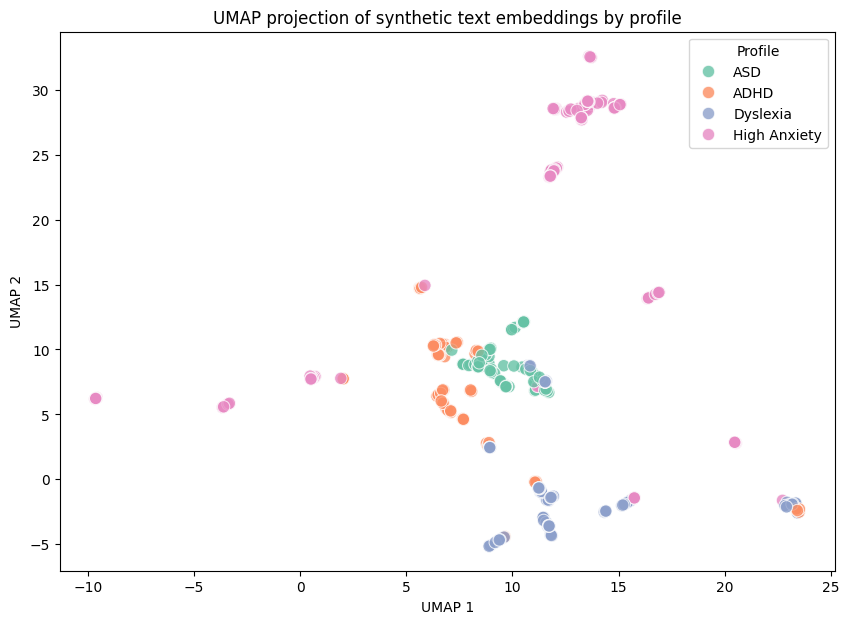

In [ ]:
!pip install -q umap-learn matplotlib seaborn

import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

df['umap_x'] = embedding_2d[:,0]
df['umap_y'] = embedding_2d[:,1]

# Plot
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=df,
    x='umap_x',
    y='umap_y',
    hue='profile_tag',
    palette='Set2',
    s=80,
    alpha=0.8
)
plt.title("UMAP projection of synthetic text embeddings by profile")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Profile")
plt.show()


Uniform Manifold Approximation and Projection - making high-dimensional data into two-dimensional.

## Similarity drops between segments in an entry

In [ ]:
import spacy
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

nlp = spacy.load("en_core_web_sm")
model = SentenceTransformer('all-MiniLM-L6-v2')

def split_text_by_topic_starts(text, starts):
    """Split text into segments using your boundary indices."""
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents]

    starts = [int(s) for s in starts]

    segments = []
    for i, start in enumerate(starts):
        end = starts[i+1] if i+1 < len(starts) else len(sentences)
        segments.append(sentences[start:end])
    return segments

def segment_similarity_drop(text, starts):
    segments = split_text_by_topic_starts(text, starts)
    seg_embeddings = []
    
    for seg in segments:
        if len(seg) == 0:
            seg_embeddings.append(np.zeros((384,)))  
        else:
            emb = model.encode(seg)
            seg_embeddings.append(emb.mean(axis=0))  
    
    drops = []
    for i in range(1, len(seg_embeddings)):
        sim = cosine_similarity(seg_embeddings[i-1].reshape(1,-1),
                                seg_embeddings[i].reshape(1,-1))[0][0]
        drops.append(1 - sim)  
    return drops

import ast

def safe_eval(x):
    if isinstance(x, str):  
        return ast.literal_eval(x)
    return x  

df['ground_truth_segments'] = df['ground_truth_segments'].apply(safe_eval)

df['segment_similarity_drop'] = df.apply(
    lambda row: segment_similarity_drop(row['synthetic_text'], row['ground_truth_segments']),
    axis=1
)

print(df[['synthetic_text','ground_truth_segments','segment_similarity_drop']].head())


                                      synthetic_text ground_truth_segments  \
0  I spent the morning organizing my planner. I a...                [1, 3]   
1  I joined a new study group today. Everyone was...                [1, 3]   
2  I reorganized my bookshelf by topic and author...                [1, 3]   
3  I spent two hours debugging my code. I finally...                [1, 3]   
4  I forgot my umbrella and got soaked. Then I mi...                [1, 2]   

  segment_similarity_drop  
0    [0.5506998598575592]  
1    [0.7148846387863159]  
2    [0.6743693351745605]  
3    [0.7993932366371155]  
4    [0.6547799706459045]  


In [ ]:
df_exploded = df.explode('segment_similarity_drop')
df_exploded['segment_similarity_drop'] = df_exploded['segment_similarity_drop'].astype(float)

summary_stats = df_exploded['segment_similarity_drop'].describe()
print(summary_stats)


count    559.000000
mean       0.843631
std        0.179665
min        0.309860
25%        0.674285
50%        1.000000
75%        1.000000
max        1.000000
Name: segment_similarity_drop, dtype: float64


The results indicate that, on average, topic boundaries in the synthetic dataset represent strong semantic shifts between adjacent segments. With a mean similarity drop of 0.84 and a median of 1.0, most transitions reflect very distinct topic changes, suggesting that consecutive segments often have little to no semantic overlap. The relatively small standard deviation (0.18) shows that this pattern is fairly consistent across the dataset, though a few smoother transitions exist, as indicated by the lower quartile values (around 0.67). In practice, this means that the synthetic journal entries tend to exhibit abrupt topic shifts rather than gradual transitions commonly seen in natural human writing. While this could be beneficial if the dataset is intended to emphasize clear topic segmentation or diagnostic contrasts between cognitive profiles, it may reduce the realism of the text if the goal is to simulate natural topic drift and coherence. Overall, the distribution suggests an overemphasis on segmentation cues, producing distinct but potentially less fluid topic progressions.

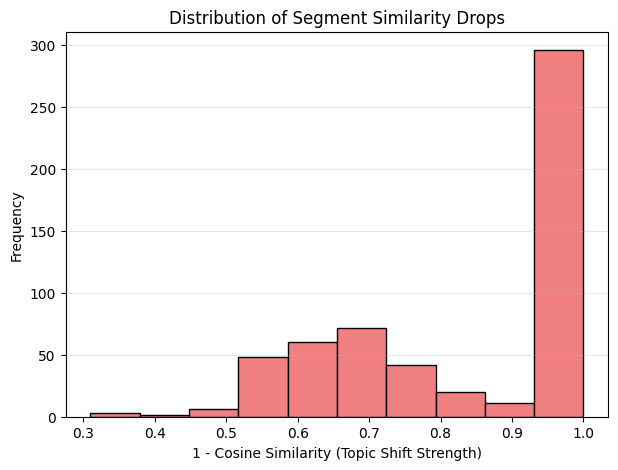

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.hist(df_exploded['segment_similarity_drop'], bins=10, color='lightcoral', edgecolor='black')
plt.title('Distribution of Segment Similarity Drops')
plt.xlabel('1 - Cosine Similarity (Topic Shift Strength)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.show()
